<a href="https://colab.research.google.com/github/YashK07/Stacking-Ensembling/blob/main/Ensemble_Stacking_in_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout
from numpy import dstack
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv('/content/Churn_Modelling.csv')

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are 3 features with string values.

In [ ]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Dataset is free of null values.

In [ ]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Since the number of countries is less and also their is no rank which can be associated with the customers of different region. Hence we use one hot encodding.

In [ ]:
#One hot encodding
geo = pd.get_dummies(df['Geography'],drop_first = True)
gen = pd.get_dummies(df['Gender'],drop_first= True)
df = pd.concat([df,gen,geo],axis=1)



In [ ]:
#Drop unnecessary data
df.drop(['Geography','Gender','Surname','RowNumber','CustomerId'],axis=1,inplace = True)

In [ ]:
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,1,0


We need to do data normalization before we send the data to train a neural network model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X = df.drop('Exited',axis=1)
y = df['Exited']

In [ ]:
#normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

array([[0.538     , 0.32432432, 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.516     , 0.31081081, 0.1       , ..., 0.        , 0.        ,
        1.        ],
       [0.304     , 0.32432432, 0.8       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.718     , 0.24324324, 0.7       , ..., 0.        , 0.        ,
        0.        ],
       [0.844     , 0.32432432, 0.3       , ..., 1.        , 1.        ,
        0.        ],
       [0.884     , 0.13513514, 0.4       , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
pd.DataFrame( )

""


In [ ]:
X_final = pd.DataFrame(columns = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Male','Germany','Spain'],data = X_scaled)

In [ ]:
X_final.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,0.0,0.0,0.0
1,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0,0.0,1.0
2,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,0.0,0.0,0.0
3,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0,0.0,0.0
4,1.000,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0,0.0,1.0


In [ ]:
#train-test-split
X_train,X_test,y_train,y_test = train_test_split(X_final,y,test_size = 0.30,random_state = 101)

Modeling

Lets create 3 neural networks to stack further.

In [ ]:
model1 = Sequential()
model1.add(Dense(50,activation = 'relu',input_dim = 11))
model1.add(Dense(25,activation = 'relu'))
model1.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 1,901
Trainable params: 1,901
Non-trainable params: 0
_________________________________________________________________


Output shape:
  N-D tensor with shape: (batch_size, ..., units).
For instance, for a 2D input with shape (batch_size, input_dim),
the output would have shape (batch_size, units).

In [ ]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

We will chose f_score 

In [ ]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
history = model1.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 100)

Epoch 1/100
219/219 [==============================] - 2s 4ms/step - loss: 0.4803 - f1_m: 0.0215 - val_loss: 0.4545 - val_f1_m: 0.1037
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4465 - f1_m: 0.1711 - val_loss: 0.4329 - val_f1_m: 0.1907
Epoch 3/100
219/219 [==============================] - 1s 2ms/step - loss: 0.4311 - f1_m: 0.2641 - val_loss: 0.4175 - val_f1_m: 0.3101
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4163 - f1_m: 0.3219 - val_loss: 0.4026 - val_f1_m: 0.4291
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 0.3971 - f1_m: 0.3857 - val_loss: 0.3845 - val_f1_m: 0.4342
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 0.3824 - f1_m: 0.4385 - val_loss: 0.3708 - val_f1_m: 0.4918
Epoch 7/100
219/219 [==============================] - 1s 2ms/step - loss: 0.3743 - f1_m: 0.4542 - val_loss: 0.3619 - val_f1_m: 0.5143
Epoch 8/100
219/219 [==============================] - 

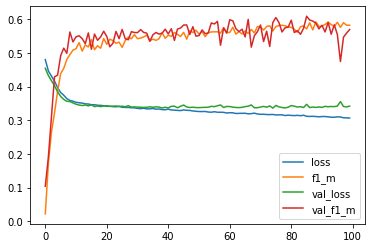

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_f1_m'])
plt.legend(['loss','f1_m',"val_loss",'val_f1_m'])
plt.show()

Lets save the model.

In [ ]:
model1.save('model1.h5')

Train 2 more different models.

In [ ]:
model2 = Sequential()
model2.add(Dense(25,activation = 'relu',input_dim = 11))
model2.add(Dense(25,activation = 'relu'))
model2.add(Dense(10,activation = 'relu'))
model2.add(Dense(1,activation = 'sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
history1 = model2.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 100)

Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 0.4868 - f1_m: 0.0023 - val_loss: 0.4712 - val_f1_m: 0.1014
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 0.4562 - f1_m: 0.1140 - val_loss: 0.4506 - val_f1_m: 0.1049
Epoch 3/100
219/219 [==============================] - 1s 2ms/step - loss: 0.4373 - f1_m: 0.2452 - val_loss: 0.4238 - val_f1_m: 0.3343
Epoch 4/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4215 - f1_m: 0.3265 - val_loss: 0.4115 - val_f1_m: 0.3790
Epoch 5/100
219/219 [==============================] - 1s 2ms/step - loss: 0.4081 - f1_m: 0.4001 - val_loss: 0.3988 - val_f1_m: 0.4497
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 0.3918 - f1_m: 0.4304 - val_loss: 0.3836 - val_f1_m: 0.5028
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3806 - f1_m: 0.4566 - val_loss: 0.3711 - val_f1_m: 0.5116
Epoch 8/100
219/219 [==============================] - 

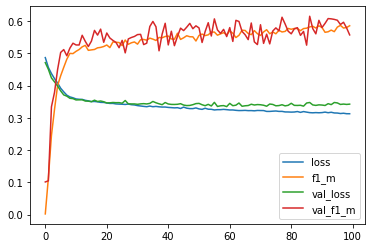

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['f1_m'])
plt.plot(history1.history['val_loss'])
plt.plot(history1.history['val_f1_m'])
plt.legend(['loss','f1_m',"val_loss",'val_f1_m'])
plt.show()

In [ ]:
model2.save('model2.h5')

In [ ]:
model3 = Sequential()
model3.add(Dense(50,activation = 'relu',input_dim = 11))
model3.add(Dense(25,activation = 'relu'))
model3.add(Dense(25,activation = 'relu'))
model3.add(Dropout(0.1))
model3.add(Dense(10,activation = 'relu'))
model3.add(Dense(1,activation = 'sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
history3 = model3.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 100)

Epoch 1/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5193 - f1_m: 0.0155 - val_loss: 0.4691 - val_f1_m: 0.0000e+00
Epoch 2/100
219/219 [==============================] - 1s 2ms/step - loss: 0.4561 - f1_m: 0.1286 - val_loss: 0.4419 - val_f1_m: 0.1439
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 0.4373 - f1_m: 0.2212 - val_loss: 0.4231 - val_f1_m: 0.2576
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 0.4204 - f1_m: 0.3233 - val_loss: 0.4020 - val_f1_m: 0.3486
Epoch 5/100
219/219 [==============================] - 0s 2ms/step - loss: 0.3970 - f1_m: 0.3934 - val_loss: 0.3780 - val_f1_m: 0.4145
Epoch 6/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3772 - f1_m: 0.4554 - val_loss: 0.3780 - val_f1_m: 0.4106
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3693 - f1_m: 0.4877 - val_loss: 0.3510 - val_f1_m: 0.5282
Epoch 8/100
219/219 [==============================

In [ ]:
model3.save('model3.h5')

In [ ]:
model4 = Sequential()
model4.add(Dense(50,activation = 'relu',input_dim = 11))
model4.add(Dense(25,activation = 'relu'))
model4.add(Dropout(0.1))
model4.add(Dense(10,activation = 'relu'))
model4.add(Dense(1,activation = 'sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
history4 = model4.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 100)

Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 0.5005 - f1_m: 0.0201 - val_loss: 0.4595 - val_f1_m: 0.0510
Epoch 2/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4521 - f1_m: 0.1377 - val_loss: 0.4386 - val_f1_m: 0.0522
Epoch 3/100
219/219 [==============================] - 0s 2ms/step - loss: 0.4345 - f1_m: 0.2037 - val_loss: 0.4219 - val_f1_m: 0.1785
Epoch 4/100
219/219 [==============================] - 1s 2ms/step - loss: 0.4152 - f1_m: 0.3303 - val_loss: 0.4005 - val_f1_m: 0.3143
Epoch 5/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3958 - f1_m: 0.4198 - val_loss: 0.3799 - val_f1_m: 0.4911
Epoch 6/100
219/219 [==============================] - 0s 2ms/step - loss: 0.3800 - f1_m: 0.4616 - val_loss: 0.3687 - val_f1_m: 0.5437
Epoch 7/100
219/219 [==============================] - 0s 2ms/step - loss: 0.3724 - f1_m: 0.4750 - val_loss: 0.3575 - val_f1_m: 0.5220
Epoch 8/100
219/219 [==============================] - 

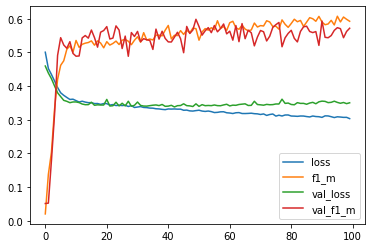

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['f1_m'])
plt.plot(history4.history['val_loss'])
plt.plot(history4.history['val_f1_m'])
plt.legend(['loss','f1_m',"val_loss",'val_f1_m'])
plt.show()

In [ ]:
model4.save('model4.h5')

In [ ]:
dependencies = {
    'f1_m': f1_m
}


In [ ]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = '/content/model' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename,custom_objects=dependencies)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [ ]:
n_members = 4
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded /content/model1.h5
>loaded /content/model2.h5
>loaded /content/model3.h5
>loaded /content/model4.h5
Loaded 4 models


In [ ]:

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat #
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [ ]:

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression() #meta learner
	model.fit(stackedX, inputy)
	return model

In [ ]:
model = fit_stacked_model(members, X_test,y_test)

In [ ]:

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [ ]:

# evaluate model on test set
yhat = stacked_prediction(members, model, X_test)
score = f1_m(y_test/1.0, yhat/1.0)
print('Stacked F Score:', score)

Stacked F Score: tf.Tensor(0.6007751457920235, shape=(), dtype=float64)


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
i = 0
for model in members:
    i+=1
    pred = model.predict_classes(X_test)
    score = f1_score(y_test,pred)
    print('F-Score of model {} is '.format(i),score)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

F-Score of model 1 is  0.5901328273244781
F-Score of model 2 is  0.5849802371541502


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F-Score of model 3 is  0.5935483870967743


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


F-Score of model 4 is  0.5987144168962351


# Stacked Model give f1 score of 0.6007 which is higher than any other model taken alone.